# QF 600 Asset Pricing | YU Lingfeng
## `Homework 4` | Efficient Frontier Revisit

### <font color = green> Activation of necessary libraries. </font>

In [1]:
# !pip install matplotlib
# !pip install --upgrade openpyxl
# !pip install nbconvert

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime

from IPython.display import display
from IPython.display import Image
import random
import warnings

# Ignore all warnings (not recommended for production code)
warnings.filterwarnings("ignore")

In [3]:
def generate_w(n_asset, n_samples):
    col_names = []
    for i in range(n_asset):
        col_names += [f'w{i+1}']
    w = []
    for j in range(n_samples):
        w_rand = []
        for i in range(n_asset):
            w_rand += [random.uniform(0, 1)]

        w += [w_rand] 
    w = pd.DataFrame(w)
    w.columns = col_names
    w['sum'] = w.sum(axis = 1)
    for col in w.iloc[:,:-1].columns:
        w[col] = w[col] / w['sum']
    w['Norm_sum'] = w.iloc[:,:-1].sum(axis = 1) 
    return w.iloc[:, :-2]



In [4]:
def generate_w_reciprocal(n_asset, n_samples):
    col_names = []
    for i in range(n_asset):
        col_names += [f'w{i+1}']
    w = []
    for j in range(n_samples):
        w_rand = []
        for i in range(n_asset):
            w_rand += [1/random.uniform(0, 1)]

        w += [w_rand] 
    w = pd.DataFrame(w)
    w.columns = col_names
    w['sum'] = w.sum(axis = 1)
    for col in w.iloc[:,:-1].columns:
        w[col] = w[col] / w['sum']
    w['Norm_sum'] = w.iloc[:,:-1].sum(axis = 1) 
    return w.iloc[:, :-2]    

In [5]:
t = generate_w_reciprocal(10, 4)
t

,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10
0,0.108562,0.074409,0.081591,0.073261,0.055725,0.101348,0.047781,0.300262,0.052293,0.104768
1,0.052349,0.046177,0.071664,0.058530,0.055177,0.067431,0.064662,0.451980,0.037076,0.094956
2,0.077710,0.099610,0.131933,0.141155,0.079010,0.095692,0.119795,0.103495,0.072376,0.079224
3,0.078178,0.042369,0.072375,0.070103,0.136825,0.039339,0.129561,0.050542,0.238674,0.142034


### <font color = "blue"> `IMPORT` dataset: `Industry_Portfolios.xlsx`. `Market_Portfolio.csv` </font> 
### <font color = "blue"> Validate dataset

> ### Question 1: Minimum-Tracking-Error Frontier

#### Q1.1 minimum-tracking-error frontier generated by the ten industry portfolios.

In [6]:
Ind_R = pd.read_csv('Industry_Portfolios.csv')
Mkt_R = pd.read_csv('Market_Portfolio.csv')

In [7]:
def Min_Tracking_Error_Frontier(Portfolio_R, Market_R, Rf, start, end, step):
    col_names = list(Portfolio_R.columns)
    result = 0
    R_i = Portfolio_R.iloc[:,1:]
    for col in R_i.columns:
        R_i[col] = R_i[col] - Mkt_R.iloc[:,1]
    R_i_matrix = R_i.iloc[:, :].to_numpy()
    
    R_i_mean = R_i.mean(axis = 0)
    R_i_mean = pd.DataFrame(R_i_mean)
    R_i_mean.columns = ['Ri_mean']
    R_i_mean['Ri_std'] = R_i.std(axis = 0)
    R_i_mean['Ri_var'] = R_i_mean['Ri_std'] ** 2

    # Calculate the variance-covariance matrix
    # Setting rowvar=False means that each column represents a variable (asset), 
    # and each row represents an observation (sample).
    V = np.cov(R_i_matrix, rowvar=False)
    # Calculate the V-inverse
    V_inv = np.linalg.inv(V)

    # Calculate the R-prime (transpose)
    R_prime = R_i_mean['Ri_mean'].to_numpy()
    R = np.transpose(R_prime)
    # create the unit vector e
    e_prime = np.ones(len(col_names) - 1)
    e = e_prime.T

    alpha = R_prime @ V_inv @ e
    zeta = R_prime @ V_inv @ R
    delta = np.dot(np.dot(e_prime, V_inv), e)    

    Rmv = alpha / delta
    Rp = np.arange(start, end, step)
    Var = (1 / delta) + (delta / (zeta * delta - alpha ** 2) ) * ((Rp - Rmv) ** 2)
    st_d = Var ** 0.5
    
    frontier_plot = [Rp, st_d]
    
    frontier_plot = pd.DataFrame(frontier_plot)
    frontier_plot.index = ['Y', 'X']

    # name sigma_p for differentiate with previous st_d, for tangency line
    sigma_p = (Rp - Rf) / ((zeta - 2 * alpha * Rf + delta * (Rf**2)) ** 0.5)
      
    # Information Ratio for tangency portfolio = (Rtg - Rf) / sigma_tg
    Info_ratio_tg = (zeta - 2 * alpha * Rf + delta * (Rf**2)) ** 0.5
    
    Rtg = (alpha * Rf - zeta) / (delta * Rf - alpha)
    # Weightage w* = a + b * Rp, on Lecture Notes 2 Page 12
    w_star = ((delta * Rtg - alpha) / (zeta * delta - alpha ** 2)) *\
                                    (V_inv @ R) + ((zeta - alpha * Rtg) / \
                                    (zeta * delta - alpha ** 2)) * (V_inv @ e)    
    w_star = pd.DataFrame(w_star)
    w_star.columns = ['Weightage']
    w_star.index = col_names[1:]
    print(alpha)
    return [frontier_plot.T, sigma_p, V, R_i_mean, Info_ratio_tg, w_star]

In [8]:
MTEF = Min_Tracking_Error_Frontier(Ind_R, Mkt_R, 0, 0, 0.105, 0.005)
MTEF[-1]

2.932127882630618


,Weightage
NoDur,0.052634
Durbl,0.000153
Manuf,0.137627
Enrgy,0.087032
HiTec,0.179353
Telcm,0.071074
Shops,0.106884
Hlth,0.102776
Utils,0.040162
Other,0.222304


In [9]:
information_ratio = MTEF[-2]
weights_tangency = MTEF[-1]

In [10]:
def plot_frontier(df_coordinates, line_p, x_label, y_label, plt_title,\
                  start, end, step, tan=True):
    partition = (len(df_coordinates)) // 2

    plt.figure(figsize=(8, 6))
    # Create a line plot for y1
    plt.plot(df_coordinates['X'][:partition+1], 
             df_coordinates['Y'][:partition+1], label='Inefficient',
             marker='s', linestyle='--')

    # Create a line plot for y2
    plt.plot(df_coordinates['X'][partition:], 
             df_coordinates['Y'][partition:], label='Efficient Frontier',
             marker='o', linestyle='-')
    

    # Create a line plot for y1
    if tan:
        plt.plot(line_p, np.arange(start, end, step),\
                 label='tangent', linestyle='-') 
    # Add a title
    plt.title(plt_title)
    plt.yticks(np.arange(start, end, step))
    # plt.xlim(0,5.5)
    # Add labels and a legend
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()

    plt.savefig(f'{plt_title}.png')
    # Show the plot
    plt.show()    

    return

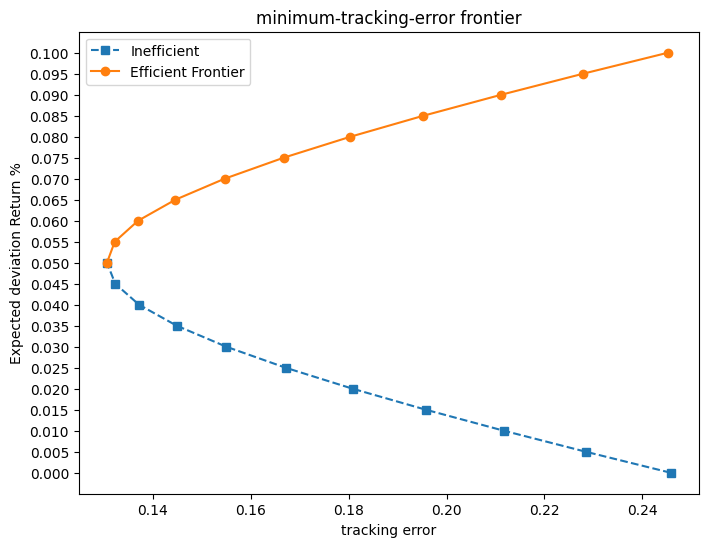

In [11]:
plot_frontier(MTEF[0], MTEF[1], "tracking error", 
              'Expected deviation Return %', 
              'minimum-tracking-error frontier',
             0, 0.105, 0.005, False)

#### Q1.2 minimum-tracking-error frontier with tangency line.

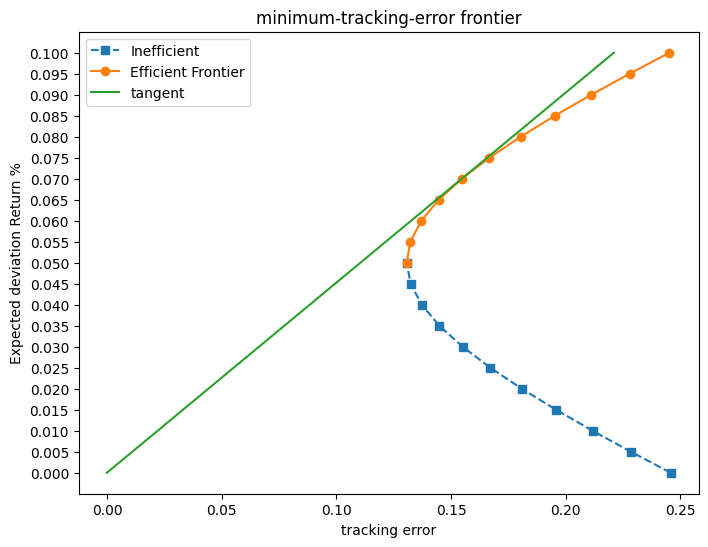

In [12]:
plot_frontier(MTEF[0], MTEF[1], "tracking error", 
              'Expected deviation Return %', 
              'minimum-tracking-error frontier',
             0, 0.105, 0.005, True)

#### Q1.3 Information Ratio and Tangency porfolio.

In [13]:
information_ratio

0.45248753961993227

In [14]:
weights_tangency

,Weightage
NoDur,0.052634
Durbl,0.000153
Manuf,0.137627
Enrgy,0.087032
HiTec,0.179353
Telcm,0.071074
Shops,0.106884
Hlth,0.102776
Utils,0.040162
Other,0.222304


> Question 2: Monte Carlo simulation on minimum-variance frontier without short sales

In [15]:
def plot_scatter(df_coordinates):
    plt.scatter(df_coordinates['X'], df_coordinates['Y'], \
                color='blue', marker='o', s=1)

    # Adding labels and a legend
    plt.xlabel('standard deviation of return')
    plt.ylabel('mean return')
    plt.title('Minimum-Variance Frontier w/o Short Sales')
    plt.legend(labels=[f'{len(df_coordinates):.1e} data points'])

    # Show the plot
    plt.show()    
    return

In [16]:
def Monte_Carlo_simulation(df_w, R_arr, V_matrix):
    coordinates = pd.DataFrame(index=df_w.index, columns=['X', 'Y'])
    weights_array = df_w.to_numpy()

    coordinates['Y'] = weights_array @ R_arr
    variances = np.einsum('ij,jk,ik->i', weights_array, V, weights_array)
    coordinates['X'] = variances**0.5

    return coordinates

In [17]:
Rp = Ind_R.iloc[:, 1:].mean(axis = 0).to_numpy()
Rp = Rp.T
matrix = Ind_R.iloc[:, 1:].to_numpy()
# Setting rowvar=False means that each column represents a variable (asset), 
# and each row represents an observation (sample).
V = np.cov(matrix, rowvar=False)

In [18]:
V

array([[11.19342216, 18.44966611, 14.10490703, 10.5313412 , 12.92294937,
        11.96807831, 10.17083232,  9.95311174,  7.86665347, 14.4384085 ],
       [18.44966611, 69.92057703, 39.1780972 , 27.0197944 , 35.4666521 ,
        27.49054314, 27.44473081, 16.82400308, 12.74613641, 39.36198711],
       [14.10490703, 39.1780972 , 28.19897006, 23.14537986, 24.61873929,
        19.55014973, 17.62286678, 13.59644703, 11.4406123 , 26.31342279],
       [10.5313412 , 27.0197944 , 23.14537986, 36.98493308, 19.26727584,
        15.36681682, 11.29780011,  9.63032658, 14.02716804, 18.32046915],
       [12.92294937, 35.4666521 , 24.61873929, 19.26727584, 28.95722027,
        18.70827342, 17.83711471, 13.25406408, 10.30418676, 23.85547048],
       [11.96807831, 27.49054314, 19.55014973, 15.36681682, 18.70827342,
        19.78722739, 14.16935566, 11.50659873, 10.99159564, 19.61083576],
       [10.17083232, 27.44473081, 17.62286678, 11.29780011, 17.83711471,
        14.16935566, 16.75908392, 10.17884947

In [19]:
def Monte_Carlo_simulation_batch(N, n, R_arr, V_matrix, n_assets,\
                                 func=generate_w_reciprocal):
    result = pd.DataFrame(columns=['X', 'Y'])
    if n > 10000:
        n = 10000
    for batch in range(int(N/n)):
        result = pd.concat([result, Monte_Carlo_simulation(func(n_assets, n), \
                                                           R_arr, V_matrix)])
    
    result.index = range(N)
    return result
    

In [20]:
w_simulation = Monte_Carlo_simulation_batch(100000, 100, Rp, V, 10, generate_w)

In [21]:
w_simulation.describe()

,X,Y
count,100000.000000,100000.000000
mean,4.281122,0.862405
std,0.264410,0.035240
min,3.368779,0.714477
25%,4.094499,0.838480
50%,4.272220,0.862430
75%,4.454287,0.886325
max,5.957121,1.007486


In [22]:
w_r_simulation = Monte_Carlo_simulation_batch(100000, 100, Rp, V, 10,\
                                              generate_w_reciprocal)

In [23]:
w_r_simulation.describe()

,X,Y
count,100000.000000,100000.000000
mean,4.419131,0.862163
std,0.672225,0.083249
min,3.170220,0.489235
25%,4.000556,0.823905
50%,4.303694,0.865092
75%,4.684361,0.898108
max,8.360221,1.231024


#### Q1.1 minimum-tracking-error frontier generated by the ten industry portfolios.

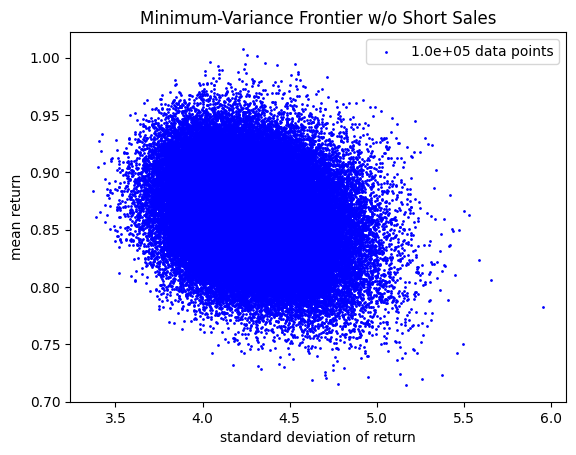

In [24]:
plot_scatter(w_simulation)

#### Q2.2 Normalised w-reciprocal vector generation of 1e5 data points 

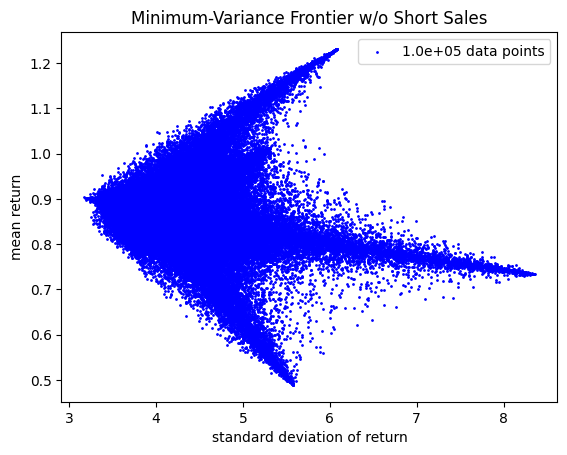

In [25]:
plot_scatter(w_r_simulation)

## QF 600 Asset Pricing | `Homework 4` | YU Lingfeng
## Efficient Frontier Revisit | Submission 1

> ### Question 1: Minimum-Tracking-Error Frontier

In [26]:
print(f"The information ratio is {information_ratio}\n")
print("Weightage on tangency portfolio is:")
weights_tangency

The information ratio is 0.45248753961993227

Weightage on tangency portfolio is:


,Weightage
NoDur,0.052634
Durbl,0.000153
Manuf,0.137627
Enrgy,0.087032
HiTec,0.179353
Telcm,0.071074
Shops,0.106884
Hlth,0.102776
Utils,0.040162
Other,0.222304


#### Q1.1 minimum-tracking-error frontier generated by the ten industry portfolios.

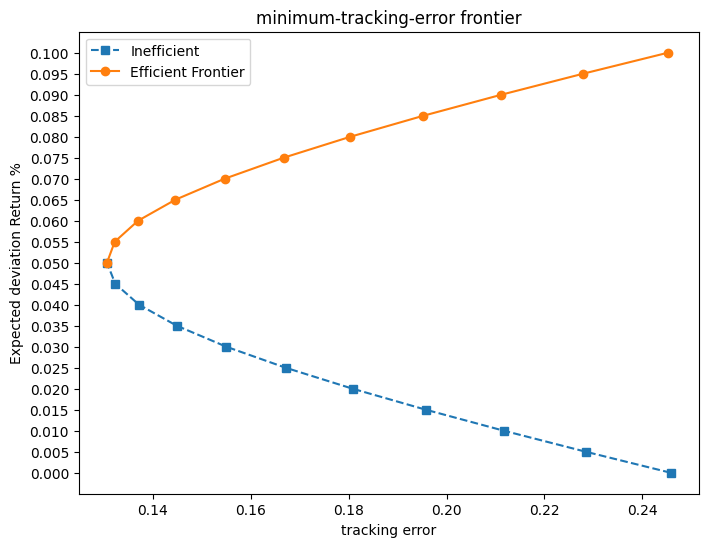

In [27]:
plot_frontier(MTEF[0], MTEF[1], "tracking error", 
              'Expected deviation Return %', 
              'minimum-tracking-error frontier',
             0, 0.105, 0.005, False)

#### Q1.2 minimum-tracking-error frontier with tangency line.

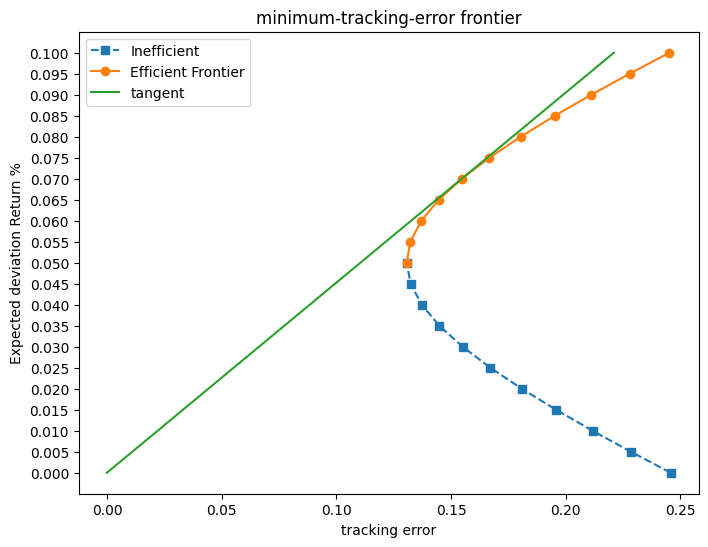

In [28]:
plot_frontier(MTEF[0], MTEF[1], "tracking error", 
              'Expected deviation Return %', 
              'minimum-tracking-error frontier',
             0, 0.105, 0.005, True)

> Question 2: Monte Carlo simulation on minimum-variance frontier without short sales

#### Q2.1 Normalised w vector generation of 1e5 data points

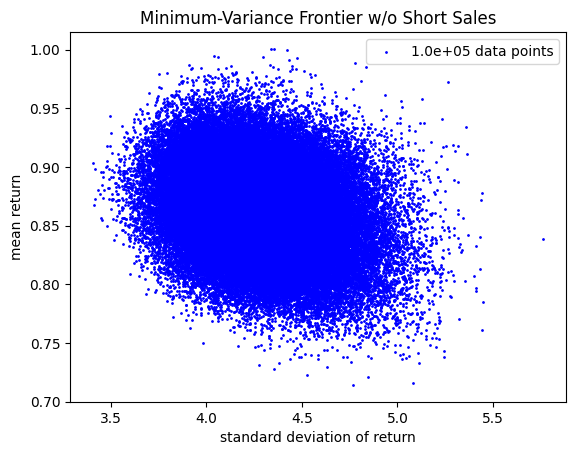

In [29]:
plot_scatter(Monte_Carlo_simulation_batch\
             (100000, 100, Rp, V, 10, generate_w))

#### Q2.2 Normalised w-reciprocal vector generation of 1e5 data points 

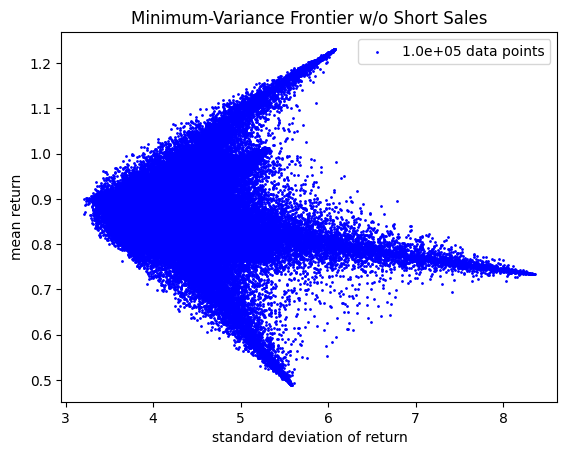

In [30]:
plot_scatter(Monte_Carlo_simulation_batch\
             (100000, 100, Rp, V, 10, generate_w_reciprocal))